# Introduction

In [121]:
import os
import sys
import csv
import datetime
import pandas as pd
import xgboost as xgb
import keras
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from tsfresh import extract_features
from keras.models import Model, load_model
from keras.layers import Input, Activation, Dense, concatenate, LSTM, GRU
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from random import uniform, randint

# Data Importation

In [2]:
dfx = pd.read_csv('../data/x_train.csv').set_index('ID')
dfy = pd.read_csv('../data/y_train.csv').set_index('ID')
dfx_test = pd.read_csv('../data/x_test.csv').set_index('ID')

In [3]:
dfy.head()
dfx_test.tail()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
28599,9456,1.501446,1.935893,2.100466,2.144410,2.259503,2.269867,2.292989,2.346420,2.724702,...,20.970412,20.984293,20.997030,21.016212,21.039446,21.044450,21.277555,21.723172,22.037007,22.061580
28600,10064,0.059309,0.116247,0.163038,0.262012,0.301379,1.813054,2.068066,2.168285,2.232430,...,21.518761,22.137357,22.504569,23.102718,23.155953,23.254136,23.302653,23.480564,23.539625,23.585673
28601,10045,0.563164,1.563625,1.677879,1.881264,2.583920,2.948714,3.112856,3.299712,6.040656,...,22.736962,22.842219,22.905865,22.971377,22.982869,23.614314,23.650248,23.807894,24.425525,25.271358
28602,9570,1.052182,1.066127,1.805688,1.824387,1.864275,2.420648,2.431845,2.757334,3.235232,...,35.510581,35.700678,37.062503,37.789828,38.569837,39.213227,41.504263,41.963118,41.983141,42.038623
28603,9836,0.004843,0.026412,0.033590,0.307083,0.311297,0.426553,0.449229,0.453311,1.199124,...,17.048710,17.993623,18.675683,18.827421,18.847187,18.923304,18.929989,19.166302,19.362858,19.370905


In [4]:
if dfy.shape[0] == dfx.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

* **Sanity check:** diff etat1/etat2, neuron_id usefulness

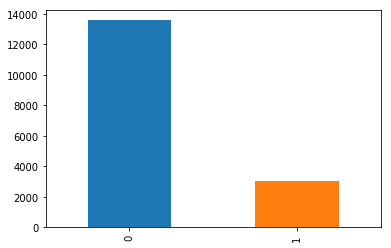

In [5]:
# Différence entre le nombre d'etats 1 et d'etats 0.
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [6]:
# Should we keep the neuron_id col ?
xtest_uniques = dfx_test.neuron_id.unique()
x_uniques = dfx.neuron_id.unique()
diff = [x for x in x_uniques if x in xtest_uniques]
print("There are {} neuron_ids in common between the train and test sets.".format(len(diff)))

There are 1 neuron_ids in common between the train and test sets.


In [7]:
dfx.neuron_id.unique().shape

(458,)

* **Balance dataset:** Under-sample class2 to have same number of samples in both classes

In [116]:
# SET SEED pour reproducibilité
def balance_data(X, y, method="undersampling", split=0.95):
    """ Return balanced training dataset obtained by undersampling class 2. """
    # Extract class2 indices from Y
    y_class1_ix = np.where(y == 1)[0]
    y_class2_ix = np.where(y == 0)[0]
    
    # Under-sample class2 to get balanced classes
    if method == "undersampling":
        y_class2_ix_undersampled = np.random.choice(y_class2_ix, len(y_class1_ix))

    # Split train & val
    y_class1_ix = np.random.choice(y_class1_ix, int(len(y_class1_ix) * split))
    y_class2_ix_undersampled = np.random.choice(y_class2_ix, int(len(y_class1_ix) * split))
    
    # Concatenate the undersampled_class2_array and the class1_array
    balanced_ix = np.concatenate((y_class1_ix, y_class2_ix_undersampled), axis=0)
    np.random.shuffle(balanced_ix)
    
    # Create X_train dataset (Keras will do the val split)
    X_train = X[balanced_ix]
    y_train = y[balanced_ix]
    
    # Create **UNOFFICIAL** X_val containing only 0s.
    balanced_ix_val = np.in1d(range(X.shape[0]), balanced_ix)
    X_val = X[~balanced_ix_val]
    y_val = y[~balanced_ix_val]
    
    return X_train, y_train, X_val, y_val

* **Extract features:** Use tsfresh to perform feature engineering

In [9]:
# WIP !
def extract_tsfresh(dfx):
    dfx = pd.DataFrame(dfx.stack(), columns=['spike_time']).reset_index()
    extracted_features = extract_features(dfx, column_id="ID", column_value="spike_time", column_sort="level_1")
    dfx = dfx.pivot(index='ID', columns='level_1', values='spike_time')
    dfx.columns = [int(col[col.find('_') + 1:]) for col in dfx.columns]
    dfx = dfx.sort_index(axis=1).join(extracted_features)
    dfx = dfx.dropna(axis='columns')
    fname = "../data/features{}.csv".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    dfx.to_csv(fname, sep=',')
    return dfx

In [10]:
def get_save(fn):
    save = pd.read_csv(fn)
    save = save.dropna(axis='columns').set_index('ID')
    return save

In [11]:
def isolate_features(X):
    ts_arr = X[:,:50]
    fe_arr = X[:,50:]
    fe_arr = np.reshape(fe_arr, fe_arr.shape[:-1])
    """
    Obsolete: repeat engineered features for each 50 timestep of a sample
    X = np.concatenate((np.repeat(features_arr.transpose(0,2,1), 50, axis=1), nofeat_arr), axis=2)
    !!! Will kill 42's mac !!!
    """
    return ts_arr, fe_arr

In [12]:
def drop_unique_col(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)

* **Standardization:** Scale features

In [13]:
def standardize_data(X):
    """Simple standardization that accepts both a single arr, AND 2 arrays in case of RNN+FeatureEngineering"""
    def standardize(X):
        X -= np.mean(X, axis=0)
        X /= (np.std(X, axis=0) + sys.float_info.epsilon)
        X = np.nan_to_num(X)
        return X

    if len(X) > 1:
        X = (X[0], standardize(X[1]))
    else:
        X = standardize(X)
    return X

* **Create Xtrain ytrain:** numpy array from df, with dimensions *(sample_nb, timestep_nb, feature_nb)*

In [97]:
def getData(dfx, dfy, 
            exclude_neuron_id=True, 
            balancing="undersample",
            standardize=False,
            differencing=False,
            get_tsfresh=False,
            get_ISI_SPIKE=False,
            testing=False,
            RNN=True,
            split=0.95,
            **extras):    
   
    if isinstance(dfx, str) and get_tsfresh:
        dfx = get_save(dfx)
        drop_unique_col(dfx)
    else:
        if exclude_neuron_id:
            # X: Exclude neuron_id column from array
            dfx = dfx.drop(columns=['neuron_id'])
        if get_tsfresh:
            dfx = extract_tsfresh(dfx)
    
    X = dfx.values
    
    X = X[..., np.newaxis]
    y = np.reshape(dfy.values, (dfy.values.shape[0],))
       
    if balancing == "undersample" and not testing:
        X, y, X_val, y_val = undersample(X, y, split)
    else:
        X_val = np.ones(X.shape)
        y_val = np.ones(y.shape)
        
    # Convert from timeseries to interval
    if differencing:
        X[:,1:50] -= X[:,:49]
        X_val[:,1:50] -= X_val[:,:49]
 
    if get_ISI_SPIKE:
        pass
    
    if get_tsfresh:
        X = isolate_features(X)
        X_val = isolate_features(X_val)
#    elif get_tsfresh:
#        X = np.reshape(X, X.shape[:2])
        
    if standardize:
        X = standardize_data(X)
        X_val = standardize_data(X_val)
      
    return X, y, X_val, y_val

* **Deprecated:** Concatenate neuron_id to every timestep of a sample 

In [15]:
# TODO : Make a 3d numpy array from our pandas df
# Shape = [samples, timestamps, features]
"""
timesteps_arr = dfx.iloc[:,1:].values
timesteps_arr = timesteps_arr[..., np.newaxis]
timesteps_arr.shape

neuron_arr = dfx.iloc[:,0].values
neuron_arr.shape

neuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)
final_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)
final_arr.shape
"""

'\ntimesteps_arr = dfx.iloc[:,1:].values\ntimesteps_arr = timesteps_arr[..., np.newaxis]\ntimesteps_arr.shape\n\nneuron_arr = dfx.iloc[:,0].values\nneuron_arr.shape\n\nneuron_arr = np.broadcast_to(neuron_arr[:,None,None], timesteps_arr.shape)\nfinal_arr = np.concatenate((timesteps_arr,neuron_arr), axis=2)\nfinal_arr.shape\n'

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Prepare experiment

In [98]:
params = {
    'name': "XGB_vanilla",
    'exclude_neuron_id': True,
    'balancing': "undersample",
    'standardize': True,
    'differencing': True,
    'get_tsfresh': True,
    'get_ISI_SPIKE': False,
    'RNN': False
}

In [66]:
def process_data(params):
    if params['get_tsfresh']:
        X = "../data/features0607182541.csv"
        X_test = "../data/features0607183651.csv"
    else:
        X = dfx
        X_test = dfx_test

    X_test, _, _, _ = getData(X_test, dfy, testing=True, **params)
    X_train, y_train, X_val, y_val = getData(X, dfy, **params)
    return X_train, y_train, X_val, y_val, X_test

In [67]:
def predict(X_test, model):
    # Predict on custom X_test
    y_pred = model.predict(X_test)
    y_pred = np.reshape(y_pred, (y_pred.shape[0],))
    print (y_pred.shape)
    
    # Convert sigmoid output to 0s and 1s
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
  
    # Format .csv in ENS style
    dfy_pred = pd.DataFrame(data=y_pred, columns=["TARGET"], dtype=int)
    dfy_pred.index.name = "ID"
    dfy_pred.index += 16635
    return dfy_pred

In [68]:
def evaluate(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred))
    print(metrics.cohen_kappa_score(y_true, y_pred))

## Run training

### Deep-Learning 1: blunt RNN

In [318]:
X_train, y_train, X_val, y_val, X_test = process_data(params)

* **Create and train model**

In [23]:
if params['get_tsfresh']:
    timestep_nb = X_train[0].shape[1]
else:
    timestep_nb = X_train.shape[1]
spike_per_ts = 1
params['cell_nb'] = 128

input_tensor = Input(shape=(timestep_nb, spike_per_ts))
X = LSTM(params['cell_nb'], return_sequences=False)(input_tensor)

if params['get_tsfresh']:
    additional_features = X_train[1].shape[1]
    fe_input = Input(shape=(additional_features,)) # A tensor containing the engineered features
    latent = Dense(32, activation='tanh')(fe_input)
    input_tensor = [input_tensor, fe_input]
    X = concatenate([X, latent])   
    
output_tensor = Dense(1, activation='sigmoid')(X)

model = Model(input_tensor, output_tensor)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 382)          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          66560       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           12256       input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [80]:
model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Train on 5504 samples, validate on 612 samples
Epoch 1/10
5504/5504 [==============================] - 25s 5ms/step - loss: 0.2177 - acc: 0.6532 - val_loss: 0.2351 - val_acc: 0.6242
Epoch 2/10
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2148 - acc: 0.6588 - val_loss: 0.2416 - val_acc: 0.6160
Epoch 3/10
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2117 - acc: 0.6644 - val_loss: 0.2444 - val_acc: 0.5899
Epoch 4/10
5504/5504 [==============================] - 22s 4ms/step - loss: 0.2087 - acc: 0.6702 - val_loss: 0.2369 - val_acc: 0.6176
Epoch 5/10
5504/5504 [==============================] - 23s 4ms/step - loss: 0.2059 - acc: 0.6835 - val_loss: 0.2425 - val_acc: 0.5948
Epoch 6/10
5504/5504 [==============================] - 21s 4ms/step - loss: 0.2035 - acc: 0.6835 - val_loss: 0.2388 - val_acc: 0.6062
Epoch 7/10
5504/5504 [==============================] - 21s 4ms/step - loss: 0.2011 - acc: 0.6924 - val_loss: 0.2381 - val_acc: 0.6095
Epoch 8/

In [82]:
history_params = [
    ('batch_size', history.params['batch_size']),
    ('epochs', history.params['epochs']),
    ('samples', history.params['samples']),
    ('val_acc', history.history['val_acc'][-1])
    ]

params.update(history_params)

* **Predict**

In [307]:
dfy_pred = predict(X_test, model)
dfy_pred[:5]

(50, 1)


AttributeError: 'tuple' object has no attribute 'ndim'

### Domain-knowledge 1: Benchmark = differencing + tsfresh feature engineering + random forest

In [118]:
scores = []
for split in np.arange(0.2, 1, 0.1):
    params['split'] = split
    X_train, y_train, X_val, y_val, X_test = process_data(params)
    print(X_train[1].shape)
    model.fit(X_train[1], y_train)
    dfy_val = predict(X_val[1], model)
    scores.append((metrics.f1_score(y_val, dfy_val), metrics.cohen_kappa_score(y_val, dfy_val)))

(733, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(15978,)
(1192, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(15573,)
(1712, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(15140,)
(2293, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(14715,)
(2934, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(14216,)
(3638, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(13635,)
(4402, 382)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(13144,)
(5228, 382)
(12558,)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [119]:
scores

[(0.2782433791485082, 0.00966278775746976),
 (0.26041173686701374, 0.011114219913250234),
 (0.2579522516878959, 0.03429710128678021),
 (0.24630541871921185, 0.03234075925862012),
 (0.24694926140012843, 0.050700558732715284),
 (0.24461670973298882, 0.0704235771852465),
 (0.22833588957055212, 0.05434366360241072),
 (0.21758538357728643, 0.05687286170157113)]

In [73]:
X_train[1].shape

(5665, 382)

* **Train**

In [100]:
#XGB
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

#SVC
#model = SVC(gamma='auto')

In [85]:
params.update(model.get_params())

params_CV = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


#search = RandomizedSearchCV(model, param_distributions=params_CV, random_state=42,
#                            n_iter=200, cv=3, verbose=1, n_jobs=4, return_train_score=True)
search = RandomizedSearchCV(model, param_distributions=params_CV, n_iter=10, scoring='roc_auc', n_jobs=4, 
                            verbose=3, random_state=1001 )

search.fit(X_train[1], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV] subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.7427169421487603, total=  24.8s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.7571078871721164, total=  24.9s
[CV] subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0, score=0.7545575896262395, total=  25.2s
[CV] subsample=0.8, min_child_weight=5, max_depth=5, g

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  3.0min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [91]:
print('\n Best estimator:')
print(search.best_estimator_)
print('\n Best normalized gini score:')
print(search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(search.best_params_)
model = search.best_estimator_


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

 Best normalized gini score:
0.6175325434928007

 Best hyperparameters:
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.6}


* **Predict**

In [93]:
dfy_pred = predict(X_test[1], model)

(11969,)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


* **Evaluate**

In [96]:
dfy_val = predict(X_val[1], model)
evaluate(y_val, dfy_val)

(12260,)
             precision    recall  f1-score   support

          0       0.95      0.47      0.63     11104
          1       0.13      0.76      0.22      1156

avg / total       0.87      0.50      0.59     12260

0.07103347029864227


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
(y_val != 0).sum()

1200

### Domain-knowledge 2: KNN with SPIKE- and ISI- synchronization distances

## Save Results

In [102]:
def saveExp(dfy_pred, model, params):
    """ Create directory in which to save predictions, experiment parameters and model object. """

    directory = "../experiments/{}".format(datetime.datetime.now().strftime("%m%d%H%M%S"))
    if not os.path.exists(directory):
        os.makedirs(directory)

    dfy_pred.to_csv(directory + '/y_pred.csv', sep=',')
    
    model.save(directory + '/model.h5')
    
    columns = []
    values = []
    for k, v in params.items():
        columns.append(k)
        values.append(v)
    params_df = pd.DataFrame(data=[values], columns=columns)
    params_df.to_csv(directory + '/params.csv', sep=';')
    return directory

# Save model
saveExp(dfy_pred, model, params)

'../experiments/0612180411'

## Load Model

In [301]:
def load_exp():
    """ Reproduce saved experience from a directory: load dataset, model, predict on x_test and evaluate. """
    
    for xp in os.scandir("../experiments"):
    
        if not xp.is_dir():
            continue
        
        model_path, params_path, y_pred_path = sorted(os.scandir(xp.path), key=lambda x: (x.is_dir(), x.name))
        model = load_model(model_path.path)
        model.summary()
        
        with open(params_path, mode='r') as infile:
            reader = csv.reader(infile, delimiter=';')
            keys, values = reader
        params = {keys[ix]:values[ix] for ix in range(len(keys))}
        for k, v in params.items():
            if v == 'True' or v == 'False':
                params[k] = v == 'True'
        X_train, y_train, X_val, y_val, X_test = process_data(params)
        if isinstance(X_train, tuple):
            print(X_train[0].shape)
        else:
            print(X_train.shape)
        print(params)
        
        dfy_val = predict(X_val, model)
        evaluate(model)
        
load_exp()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 50, 1)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 382)          0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 128)          66560       input_20[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 32)           12256       input_21[0][0]                   
__________________________________________________________________________________________________
concatenat

AttributeError: 'tuple' object has no attribute 'ndim'